<a href="https://colab.research.google.com/github/anjalii-s/Thesis-2026-/blob/main/final_GErman%2Cowen_groups%2Cshap%2Cbanzhaf%2Cmyerson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# ============================================================
# GERMAN CREDIT DATASET - COMPLETE GAME THEORY EXPLAINABILITY
# ============================================================

# Install missing libraries
!pip install xgboost
!pip install shap
!pip install imbalanced-learn
!pip install lightgbm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
import networkx as nx
from scipy import stats
from scipy.spatial.distance import cosine
from sklearn.cluster import AgglomerativeClustering

plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)

# ============================================================
# 1. LOAD AND PREPROCESS GERMAN CREDIT DATASET
# ============================================================
print("\n" + "="*80)
print("LOADING AND PREPROCESSING GERMAN CREDIT DATASET")
print("="*80)

# Load German Credit dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
cols = ['checking_status','duration','credit_history','purpose','credit_amount',
        'savings_status','employment','installment_commitment','personal_status',
        'other_parties','residence_since','property_magnitude','age',
        'other_payment_plans','housing','existing_credits','job',
        'num_dependents','own_telephone','foreign_worker','target']

df = pd.read_csv(url, sep=' ', header=None, names=cols)
df['target'] = df['target'].map({1:0, 2:1})  # 1=good(0), 2=bad(1)

X = df.drop('target', axis=1)
y = df['target']

print(f"Dataset shape: {df.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")
print(f"Default rate: {(y.mean() * 100):.2f}%")
print(f"Imbalance ratio: {sum(y==0)/sum(y==1):.2f}:1")

# Identify categorical and numeric columns
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical columns ({len(cat_cols)}): {cat_cols}")
print(f"Numeric columns ({len(num_cols)}): {num_cols}")

# Create preprocessing pipeline
cat_categories = [sorted(X[col].dropna().unique().tolist()) for col in cat_cols]
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore',
                         sparse_output=False, categories=cat_categories), cat_cols),
    ('num', StandardScaler(), num_cols)
])

# Fit preprocessor
X_processed = preprocessor.fit_transform(X)
d = X_processed.shape[1]
print(f"\nNumber of processed features: {d}")

# ============================================================
# 2. MODELS & SAMPLING STRATEGIES (GERMAN)
# ============================================================
models = {
    'RF': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'XGB': xgb.XGBClassifier(n_estimators=100, max_depth=6, random_state=42,
                            eval_metric='logloss', n_jobs=-1),
    'LGB': lgb.LGBMClassifier(n_estimators=100, max_depth=6, random_state=42,
                             verbose=-1, n_jobs=-1)
}

resamplers = {
    'None': None,
    'SMOTE': SMOTE(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42),
    'CostSensitive': 'cost'
}

# Compute class weights
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weight_dict = {int(cls): float(w) for cls, w in zip(classes, weights)}
print(f"\nClass weights: {class_weight_dict}")

# ============================================================
# 3. EXPLANATION METHODS (SAME AS BEFORE)
# ============================================================
def get_shap_reliable(pipe, X_test):
    """Get SHAP values reliably"""
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)

    try:
        explainer = shap.TreeExplainer(clf)
        sv = explainer.shap_values(X_proc)

        if isinstance(sv, list):
            return sv[1]
        elif sv.ndim == 3:
            return sv[:, :, 1]
        else:
            return sv
    except Exception as e:
        print(f"SHAP failed: {e}")
        # Fallback to permutation importance
        from sklearn.inspection import permutation_importance
        res = permutation_importance(clf, X_proc, pipe.predict(X_proc),
                                     n_repeats=3, random_state=42)
        return np.tile(res.importances_mean, (X_proc.shape[0], 1))

def compute_banzhaf(pipe, X_test, n_samples=5, max_instances=5):
    """Compute Banzhaf values"""
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    n_feat = X_proc.shape[1]
    n_inst = min(max_instances, X_proc.shape[0])
    mat = np.zeros((n_inst, n_feat))

    for i in range(n_inst):
        x = X_proc[i:i+1]
        for f in range(n_feat):
            contrib = []
            for _ in range(n_samples):
                # Create random coalition
                coal = np.random.binomial(1, 0.5, n_feat)

                # With feature f
                x_with = x.copy()
                x_with[0, f] = x[0, f] * coal[f]
                p1 = clf.predict_proba(x_with)[0, 1]

                # Without feature f
                x_without = x.copy()
                x_without[0, f] = 0
                p0 = clf.predict_proba(x_without)[0, 1]

                contrib.append(p1 - p0)
            mat[i, f] = np.mean(contrib)

    return mat

def build_feature_graph(preprocessor, X, threshold=0.25):
    """Build feature graph based on correlation"""
    X_proc = preprocessor.transform(X)
    corr = np.corrcoef(X_proc.T)

    G = nx.Graph()
    d = corr.shape[0]
    G.add_nodes_from(range(d))

    for i in range(d):
        for j in range(i+1, d):
            if abs(corr[i, j]) >= threshold:
                G.add_edge(i, j, weight=corr[i, j])

    return G, corr

def myerson_value(pipe, X_test, G, alpha=0.5, max_instances=50):
    """Compute Myerson values"""
    shap_vals = get_shap_reliable(pipe, X_test)
    shap_mean = shap_vals.mean(axis=0)
    d = len(shap_mean)
    phi = np.zeros(d)

    for i in range(d):
        neighbors = list(G.neighbors(i))
        if len(neighbors) == 0:
            phi[i] = shap_mean[i]
        else:
            neighbor_mean = np.mean([shap_mean[j] for j in neighbors])
            phi[i] = (1 - alpha) * shap_mean[i] + alpha * neighbor_mean

    n_out = min(max_instances, len(X_test))
    return np.tile(phi, (n_out, 1))

def get_feature_names_out(preprocessor):
    """Get feature names after preprocessing"""
    return preprocessor.get_feature_names_out()

def build_domain_groups(fnames):
    """Build domain-driven groups for German Credit"""
    groups = {
        "CreditHistory": [],
        "FinancialStatus": [],
        "PersonalInfo": [],
        "LoanDetails": [],
        "Employment": []
    }

    for i, name in enumerate(fnames):
        lname = name.lower()
        if any(k in lname for k in ["checking", "savings", "credit_history"]):
            groups["CreditHistory"].append(i)
        if any(k in lname for k in ["credit_amount", "property", "housing"]):
            groups["FinancialStatus"].append(i)
        if any(k in lname for k in ["age", "personal", "dependents", "residence"]):
            groups["PersonalInfo"].append(i)
        if any(k in lname for k in ["duration", "purpose", "installment"]):
            groups["LoanDetails"].append(i)
        if any(k in lname for k in ["employment", "job"]):
            groups["Employment"].append(i)

    return {g: v for g, v in groups.items() if len(v) > 0}

def build_data_groups(X_proc, n_groups=6):
    """Build data-driven groups using correlation clustering"""
    try:
        X_proc = np.nan_to_num(X_proc, nan=0.0)
        with np.errstate(invalid='ignore'):
            corr = np.corrcoef(X_proc.T)

        corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)
        np.fill_diagonal(corr, 1.0)
        corr = np.clip(corr, -1.0, 1.0)

        dist = 1 - np.abs(corr)
        dist = np.clip(dist, 0.0, 2.0)

        if X_proc.shape[1] < n_groups:
            n_groups = max(2, X_proc.shape[1] // 2)

        clustering = AgglomerativeClustering(
            n_clusters=n_groups,
            metric='precomputed',
            linkage='average'
        )
        labels = clustering.fit_predict(dist)

        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"Cluster_{lab}", []).append(idx)

        return groups, np.abs(corr)
    except Exception as e:
        print(f"Data-driven grouping failed: {e}")
        n_features = X_proc.shape[1]
        return {"Default_Group": list(range(n_features))}, np.eye(n_features)

def build_model_groups(shap_vals, n_groups=6):
    """Build model-driven groups from SHAP values"""
    try:
        shap_vals = np.nan_to_num(shap_vals, nan=0.0)

        if shap_vals.ndim == 1:
            shap_vals = shap_vals.reshape(1, -1)
        elif shap_vals.ndim == 3:
            shap_vals = shap_vals.mean(axis=2) if shap_vals.shape[2] > 1 else shap_vals.squeeze()

        if shap_vals.shape[0] < shap_vals.shape[1]:
            shap_vals = shap_vals.T

        if shap_vals.shape[0] < 2:
            n_features = shap_vals.shape[1] if shap_vals.shape[0] == 1 else shap_vals.shape[0]
            return {"Default_Group": list(range(n_features))}, np.eye(n_features)

        with np.errstate(invalid='ignore'):
            corr = np.corrcoef(shap_vals)

        corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)
        np.fill_diagonal(corr, 1.0)
        corr = np.clip(corr, -1.0, 1.0)

        dist = 1 - np.abs(corr)
        dist = np.clip(dist, 0.0, 2.0)

        n_features = corr.shape[0]
        if n_features < n_groups:
            n_groups = max(2, n_features // 2)

        clustering = AgglomerativeClustering(
            n_clusters=n_groups,
            metric='precomputed',
            linkage='average'
        )
        labels = clustering.fit_predict(dist)

        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"SHAPGroup_{lab}", []).append(idx)

        return groups, np.abs(corr)
    except Exception as e:
        print(f"Model-driven grouping failed: {e}")
        n_features = shap_vals.shape[1] if shap_vals.ndim > 1 else shap_vals.shape[0]
        return {"Default_Group": list(range(n_features))}, np.eye(n_features)

def owen_from_shap(phi, groups):
    """Compute Owen values from SHAP values using groups"""
    d = len(phi)
    out = np.zeros(d)

    for _, feats in groups.items():
        if len(feats) == 0:
            continue

        valid_feats = [f for f in feats if f < d]
        if not valid_feats:
            continue

        total = np.sum(np.abs(phi[valid_feats]))
        per = total / len(valid_feats)

        for f in valid_feats:
            sign = np.sign(phi[f]) if phi[f] != 0 else 1
            out[f] = sign * per

    return out

def stability_cv(expl_list):
    """Compute stability (coefficient of variation)"""
    if len(expl_list) < 2:
        return 1.0

    try:
        arr = np.stack([np.abs(e) for e in expl_list])
        mean = arr.mean(axis=0) + 1e-8
        std = arr.std(axis=0)
        cv_per_feature = std / mean
        return float(np.mean(cv_per_feature))
    except:
        return 1.0

def kuncheva_index(expl_list, k=5):
    """Compute Kuncheva index for top-K feature consistency"""
    if len(expl_list) < 2:
        return 0.0

    sets = []
    for exp in expl_list:
        try:
            imp = np.abs(exp).mean(axis=0).ravel()
            topk = min(k, len(imp))
            topk_indices = set(np.argsort(imp)[-topk:].tolist())
            sets.append(topk_indices)
        except:
            sets.append(set())

    if len(sets) < 2:
        return 0.0

    ki_values = []
    for i in range(len(sets)):
        for j in range(i+1, len(sets)):
            intersection = len(sets[i] & sets[j])
            if k == d:
                ki = 0.0
            else:
                ki = (intersection - (k**2)/d) / (k - (k**2)/d)
                ki = max(min(ki, 1.0), -1.0)
            ki_values.append(ki)

    return float(np.mean(ki_values)) if ki_values else 0.0

def cosine_directional_consistency(expl_list):
    """Compute cosine similarity between explanation vectors"""
    if len(expl_list) < 2:
        return 1.0

    try:
        mean_vecs = [np.mean(np.abs(e), axis=0).ravel() for e in expl_list]

        cos_sims = []
        for i in range(len(mean_vecs)):
            for j in range(i+1, len(mean_vecs)):
                if np.linalg.norm(mean_vecs[i]) == 0 or np.linalg.norm(mean_vecs[j]) == 0:
                    cos_sim = 0.0
                else:
                    cos_sim = 1 - cosine(mean_vecs[i], mean_vecs[j])
                cos_sims.append(cos_sim)

        return float(np.mean(cos_sims)) if cos_sims else 0.0
    except:
        return 0.0

def interpretability_score(cv, kuncheva, cosine_sim, beta=0.3):
    """Compute overall interpretability score"""
    return beta * (1 - cv) + beta * kuncheva + beta * cosine_sim

def normalize(s):
    """Normalize a series to [0,1]"""
    return (s - s.min()) / (s.max() - s.min() + 1e-8)

def tradeoff_metric(auc_series, I_series, alpha=0.5):
    """Compute trade-off metric between AUC and interpretability"""
    return alpha * normalize(auc_series) + (1 - alpha) * normalize(I_series)

# ============================================================
# 4. MAIN EXPERIMENT LOOP (GERMAN)
# ============================================================
print("\n" + "="*80)
print("STARTING COMPREHENSIVE EXPERIMENT - GERMAN DATASET")
print("="*80)

# Build feature graph for Myerson
print("\nBuilding feature graph for Myerson value...")
G_myerson, _ = build_feature_graph(preprocessor, X, threshold=0.25)
print(f"Graph built with {G_myerson.number_of_nodes()} nodes and {G_myerson.number_of_edges()} edges")

# Setup cross-validation
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
all_records = []

# Main experiment loop
for mname, model in models.items():
    for sname, sampler in resamplers.items():
        print(f"\n{'='*60}")
        print(f"Processing: {mname} + {sname}")
        print(f"{'='*60}")

        # Store results for each method
        aucs = []
        shap_runs, banzhaf_runs, myerson_runs = [], [], []
        owen_domain_runs, owen_data_runs, owen_model_runs = [], [], []

        for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

            # Create pipeline
            steps = [('prep', preprocessor)]
            if sampler and sampler != 'cost':
                steps.append(('samp', sampler))
            steps.append(('clf', model))
            pipe = ImbPipeline(steps)

            # Apply cost-sensitive learning if needed
            if sname == 'CostSensitive':
                if mname == 'RF':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)
                elif mname == 'XGB':
                    ratio = class_weight_dict[1] / class_weight_dict[0]
                    pipe.named_steps['clf'].set_params(scale_pos_weight=ratio)
                elif mname == 'LGB':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)

            # Train model
            pipe.fit(X_tr, y_tr)

            # Compute AUC
            auc = roc_auc_score(y_te, pipe.predict_proba(X_te)[:, 1])
            aucs.append(auc)
            print(f"  Fold {fold}: AUC = {auc:.4f}")

            # Sample for explanations
            X_sample = X_te.sample(n=min(50, len(X_te)), random_state=42)

            # 1. SHAP
            try:
                shap_vals = get_shap_reliable(pipe, X_sample)
                shap_runs.append(shap_vals)
            except Exception as e:
                print(f"    SHAP failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                shap_runs.append(np.zeros((min(50, len(X_sample)), n_features)))

            # 2. Banzhaf
            try:
                banzhaf_vals = compute_banzhaf(pipe, X_sample)
                banzhaf_runs.append(banzhaf_vals)
            except Exception as e:
                print(f"    Banzhaf failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                banzhaf_runs.append(np.zeros((min(5, len(X_sample)), n_features)))

            # 3. Myerson
            try:
                myerson_vals = myerson_value(pipe, X_sample, G_myerson)
                myerson_runs.append(myerson_vals)
            except Exception as e:
                print(f"    Myerson failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                myerson_runs.append(np.zeros((min(50, len(X_sample)), n_features)))

            # 4. Owen with different grouping strategies
            try:
                # Get SHAP values for Owen
                shap_vals_owen = get_shap_reliable(pipe, X_sample)
                phi = np.mean(shap_vals_owen, axis=0)

                # Get feature names
                fnames = get_feature_names_out(preprocessor)

                # Domain-driven groups
                dom_groups = build_domain_groups(fnames)
                owen_domain_vals = np.tile(owen_from_shap(phi, dom_groups),
                                          (min(50, len(X_sample)), 1))
                owen_domain_runs.append(owen_domain_vals)

                # Data-driven groups
                X_tr_proc = pipe.named_steps['prep'].transform(X_tr)
                data_groups, _ = build_data_groups(X_tr_proc)
                owen_data_vals = np.tile(owen_from_shap(phi, data_groups),
                                        (min(50, len(X_sample)), 1))
                owen_data_runs.append(owen_data_vals)

                # Model-driven groups
                X_tr_sample = X_tr.sample(n=min(100, len(X_tr)), random_state=42)
                shap_tr = get_shap_reliable(pipe, X_tr_sample)
                model_groups, _ = build_model_groups(shap_tr)
                owen_model_vals = np.tile(owen_from_shap(phi, model_groups),
                                         (min(50, len(X_sample)), 1))
                owen_model_runs.append(owen_model_vals)

            except Exception as e:
                print(f"    Owen failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                zeros = np.zeros((min(50, len(X_sample)), n_features))
                owen_domain_runs.append(zeros)
                owen_data_runs.append(zeros)
                owen_model_runs.append(zeros)

        # Compute average AUC
        auc_mean = np.mean(aucs)

        # Process results for each method
        method_runs = [
            ('SHAP', shap_runs),
            ('Banzhaf', banzhaf_runs),
            ('Myerson', myerson_runs),
            ('Owen_Domain', owen_domain_runs),
            ('Owen_Data', owen_data_runs),
            ('Owen_Model', owen_model_runs)
        ]

        for method_name, runs in method_runs:
            if runs:  # Only process if we have results
                cv_val = stability_cv(runs)
                kun_val = kuncheva_index(runs, k=5)
                cos_val = cosine_directional_consistency(runs)
                I_val = interpretability_score(cv_val, kun_val, cos_val)

                # Extract grouping type for Owen methods
                if method_name.startswith('Owen_'):
                    grouping = method_name.split('_')[1]
                    method_base = 'Owen'
                else:
                    grouping = 'None'
                    method_base = method_name

                all_records.append({
                    'Dataset': 'German',
                    'Model': mname,
                    'Sampler': sname,
                    'Method': method_base,
                    'Grouping': grouping,
                    'AUC': auc_mean,
                    'CV': cv_val,
                    'Stability': 1 - cv_val,
                    'Kuncheva': kun_val,
                    'Cosine': cos_val,
                    'I': I_val
                })

# ============================================================
# 5. PROCESS AND SAVE RESULTS (GERMAN)
# ============================================================
print("\n" + "="*80)
print("PROCESSING RESULTS - GERMAN DATASET")
print("="*80)

if all_records:
    metrics = pd.DataFrame(all_records)
    metrics['T(α=0.5)'] = tradeoff_metric(metrics['AUC'], metrics['I'])

    print("\nComplete Results (German Dataset):")
    print(metrics.round(4).to_string(index=False))

    # Save results
    metrics.to_csv('german_complete_results.csv', index=False)
    print("\n✓ Results saved to: german_complete_results.csv")

    # Summary by method
    print("\n" + "="*80)
    print("SUMMARY BY EXPLANATION METHOD - GERMAN")
    print("="*80)

    summary_method = metrics.groupby('Method').agg({
        'AUC': 'mean',
        'Stability': 'mean',
        'Kuncheva': 'mean',
        'Cosine': 'mean',
        'I': 'mean',
        'T(α=0.5)': 'mean'
    }).round(4)
    print(summary_method)

    # Best configurations
    print("\n" + "="*80)
    print("TOP 5 CONFIGURATIONS - GERMAN")
    print("="*80)

    top5 = metrics.nlargest(5, 'T(α=0.5)')[['Model', 'Sampler', 'Method', 'Grouping',
                                           'AUC', 'I', 'T(α=0.5)']]
    print(top5.round(4).to_string(index=False))

else:
    print("No results generated!")

print("\n" + "="*80)
print("GERMAN DATASET EXPERIMENT COMPLETE!")
print("="*80)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.8/289.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 54.7 MB/s eta 0:00:00

LOADING AND PREPROCESSING GERMAN CREDIT DATASET
Dataset shape: (1000, 21)
Target distribution: {0: 700, 1: 300}
Default rate: 30.00%
Imbalance ratio: 2.33:1

Categorical columns (13): ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']
Numeric columns (7): ['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']

Number of processed features: 48

Class weights: {0: 0.71428571


STATISTICAL VALIDATION & COMPARATIVE VISUALIZATION

1. FRIEDMAN TEST - AUC (Corrected):
Statistic: 12.0000, p-value: 0.007383
✓ Significant differences in AUC across methods

2. FRIEDMAN TEST - Interpretability (I) (Corrected):
Statistic: 32.8000, p-value: 0.000000
✓ Significant differences in Interpretability across methods

✓ Comparative plots saved as: comparative_analysis.png

COMPACT STATISTICAL SUMMARY

Performance Summary (mean ± std):
                  AUC                     I         T(α=0.5)        
                 mean     std count    mean     std     mean     std
Model Method                                                        
LGB   Banzhaf  0.7781  0.0051     4  0.3470  0.0323   0.4228  0.0731
      Myerson  0.7781  0.0051     4  0.4520  0.0117   0.5417  0.1044
      Owen     0.7781  0.0046    12  0.4945  0.0474   0.5898  0.1106
      SHAP     0.7781  0.0051     4  0.6282  0.0204   0.7413  0.1009
RF    Banzhaf  0.7853  0.0022     4  0.3329  0.0293   0.5478  0.0583


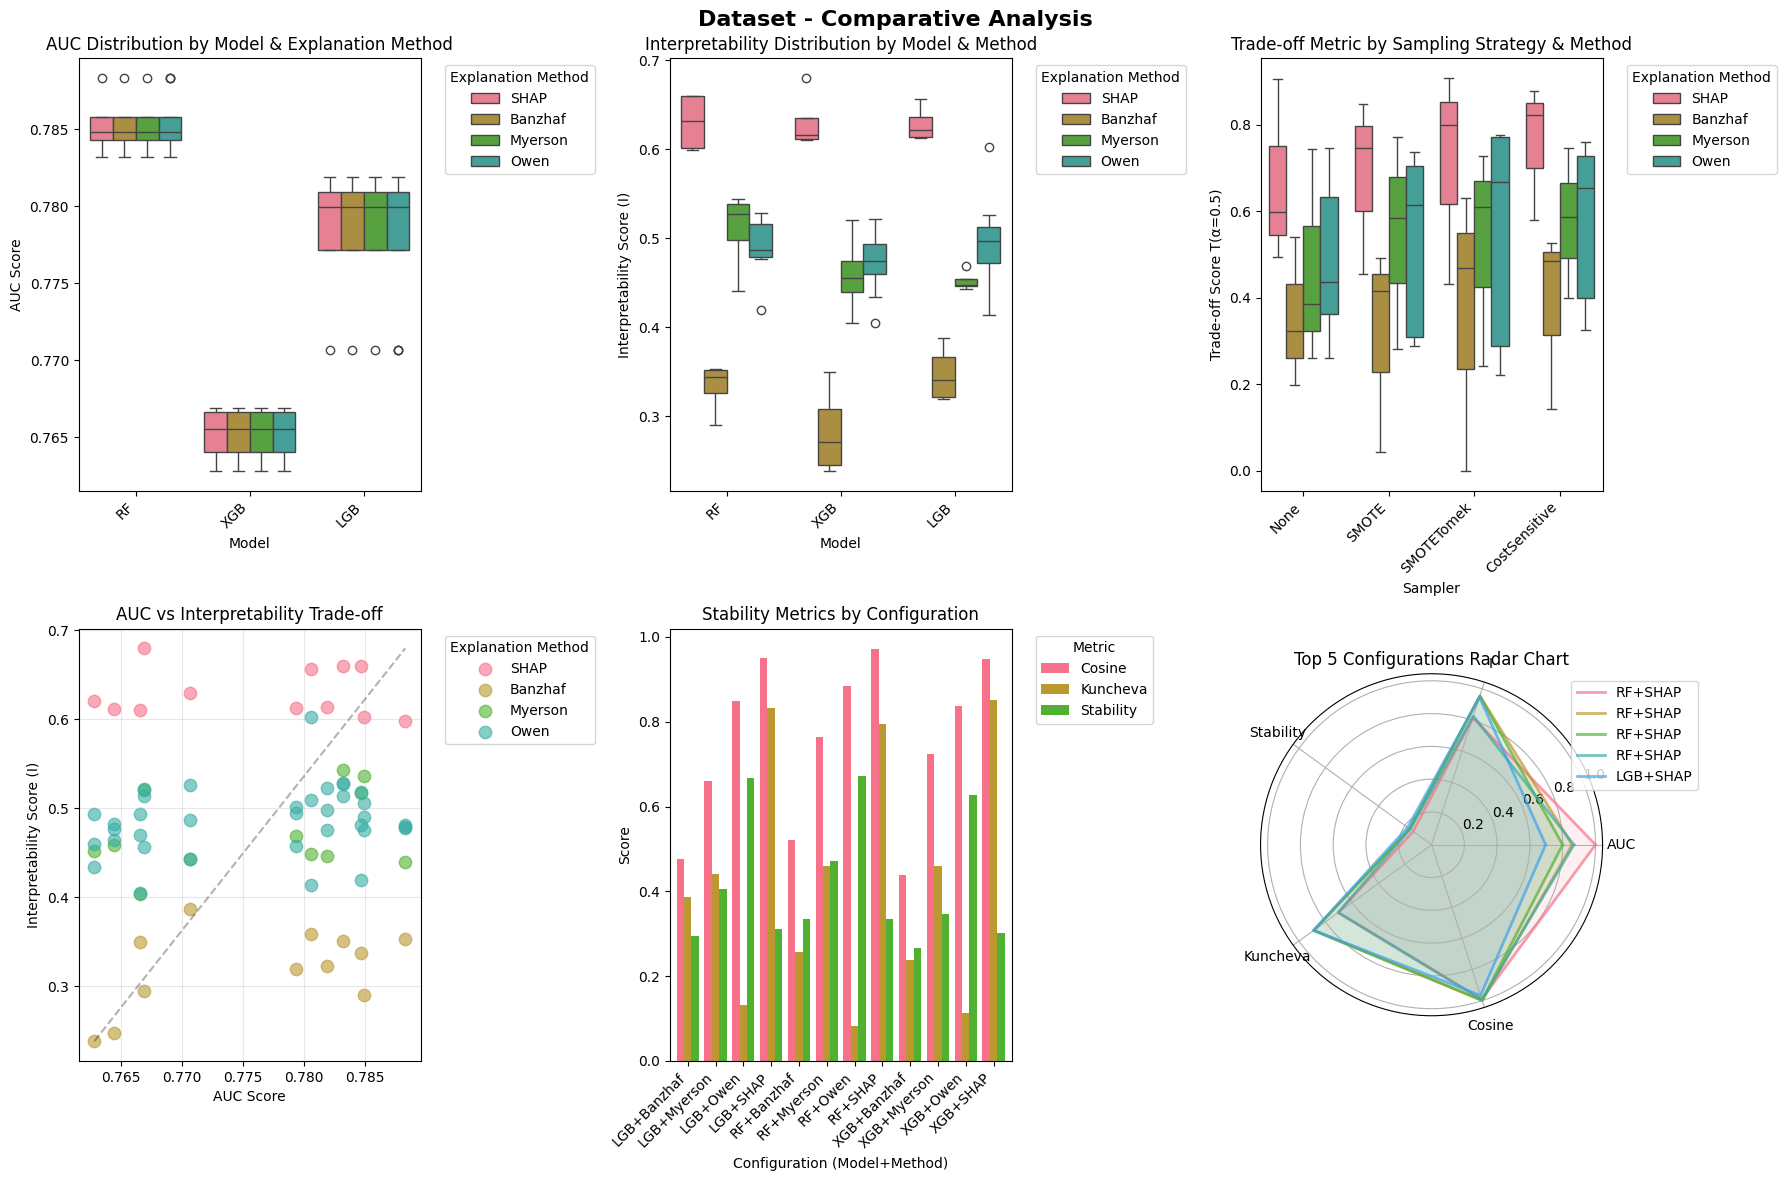

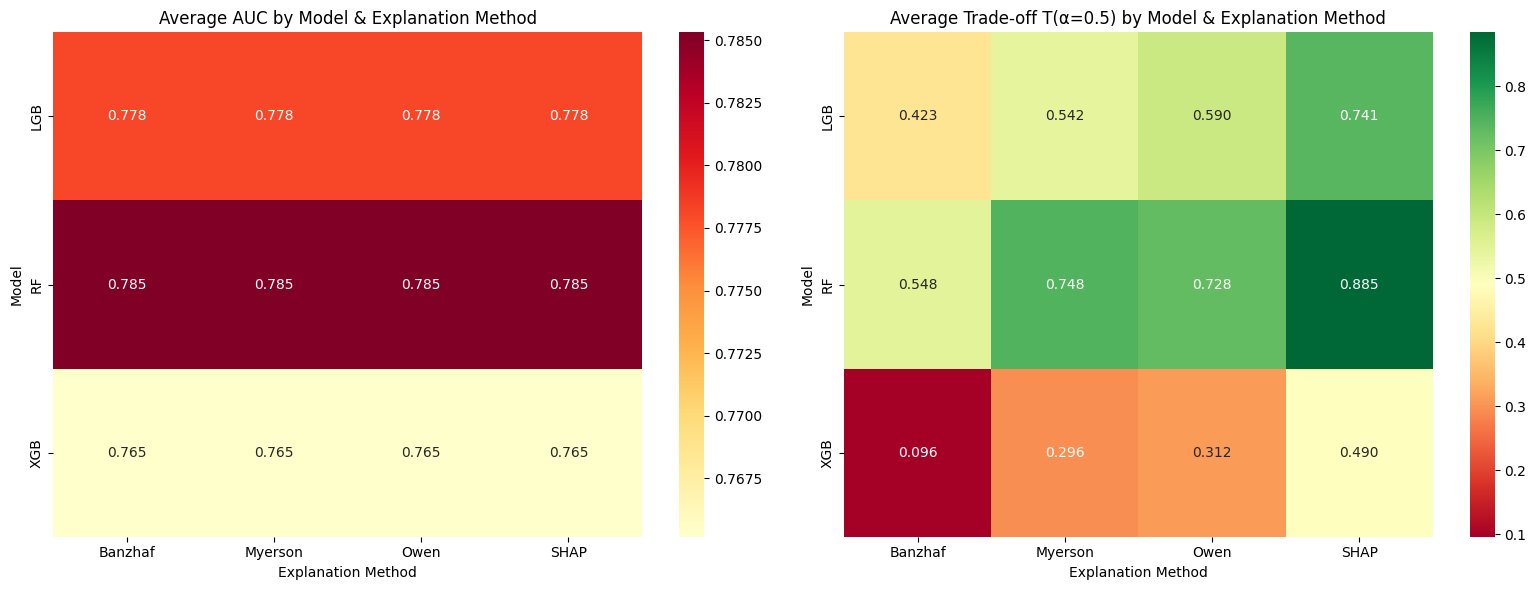


STATISTICAL VALIDATION & VISUALIZATION COMPLETE!


In [8]:
# ============================================================
# 6. STATISTICAL VALIDATION & COMPARATIVE VISUALIZATION
# ============================================================
!pip install -q scikit-posthocs

import scikit_posthocs as sp
from scipy.stats import friedmanchisquare, wilcoxon, mannwhitneyu
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("\n" + "="*80)
print("STATISTICAL VALIDATION & COMPARATIVE VISUALIZATION")
print("="*80)

# ------------------------------------------------------------
# 6.0 Sanity: ensure metrics exists and is non-empty
# ------------------------------------------------------------
if 'metrics' not in globals() or metrics.empty:
    raise ValueError("metrics DataFrame is missing or empty. Run the main experiment first.")

# ------------------------------------------------------------
# 6.1 Statistical Tests (Corrected Friedman)
# ------------------------------------------------------------

# Create a simplified configuration ID
metrics['Config_Simple'] = metrics['Model'] + '+' + metrics['Method']

print("\n1. FRIEDMAN TEST - AUC (Corrected):")

# Pivot: rows = (Model, Sampler), columns = Method
auc_pivot = metrics.pivot_table(
    index=['Model', 'Sampler'],
    columns='Method',
    values='AUC',
    aggfunc='mean'
)

# Drop methods with missing values
auc_pivot = auc_pivot.dropna(axis=1, how='any')
auc_matrix = auc_pivot.values

if auc_matrix.shape[1] >= 3:
    stat, p_value = friedmanchisquare(*[auc_matrix[:, i] for i in range(auc_matrix.shape[1])])
    print(f"Statistic: {stat:.4f}, p-value: {p_value:.6f}")
    if p_value < 0.05:
        print("✓ Significant differences in AUC across methods")
else:
    print("Not enough methods with complete AUC data for Friedman test.")

print("\n2. FRIEDMAN TEST - Interpretability (I) (Corrected):")

I_pivot = metrics.pivot_table(
    index=['Model', 'Sampler'],
    columns='Method',
    values='I',
    aggfunc='mean'
)
I_pivot = I_pivot.dropna(axis=1, how='any')
I_matrix = I_pivot.values

if I_matrix.shape[1] >= 3:
    stat, p_value = friedmanchisquare(*[I_matrix[:, i] for i in range(I_matrix.shape[1])])
    print(f"Statistic: {stat:.4f}, p-value: {p_value:.6f}")
    if p_value < 0.05:
        print("✓ Significant differences in Interpretability across methods")
else:
    print("Not enough methods with complete I data for Friedman test.")

# ------------------------------------------------------------
# 6.2 Comparative Plots
# ------------------------------------------------------------

fig = plt.figure(figsize=(18, 12))
fig.suptitle('Dataset - Comparative Analysis', fontsize=16, fontweight='bold')

# Plot 1: AUC by Model and Method
ax1 = plt.subplot(2, 3, 1)
sns.boxplot(data=metrics, x='Model', y='AUC', hue='Method', ax=ax1)
ax1.set_title('AUC Distribution by Model & Explanation Method')
ax1.set_ylabel('AUC Score')
ax1.legend(title='Explanation Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Plot 2: Interpretability by Model and Method
ax2 = plt.subplot(2, 3, 2)
sns.boxplot(data=metrics, x='Model', y='I', hue='Method', ax=ax2)
ax2.set_title('Interpretability Distribution by Model & Method')
ax2.set_ylabel('Interpretability Score (I)')
ax2.legend(title='Explanation Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# Plot 3: Trade-off Metric by Sampler
ax3 = plt.subplot(2, 3, 3)
sns.boxplot(data=metrics, x='Sampler', y='T(α=0.5)', hue='Method', ax=ax3)
ax3.set_title('Trade-off Metric by Sampling Strategy & Method')
ax3.set_ylabel('Trade-off Score T(α=0.5)')
ax3.legend(title='Explanation Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')

# Plot 4: AUC vs Interpretability Scatter
ax4 = plt.subplot(2, 3, 4)
for method in metrics['Method'].unique():
    subset = metrics[metrics['Method'] == method]
    ax4.scatter(subset['AUC'], subset['I'], label=method, alpha=0.6, s=80)
ax4.set_xlabel('AUC Score')
ax4.set_ylabel('Interpretability Score (I)')
ax4.set_title('AUC vs Interpretability Trade-off')
ax4.legend(title='Explanation Method', bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.grid(True, alpha=0.3)
# optional reference line
ax4.plot([metrics['AUC'].min(), metrics['AUC'].max()],
         [metrics['I'].min(), metrics['I'].max()], 'k--', alpha=0.3)

# Plot 5: Stability Comparison
ax5 = plt.subplot(2, 3, 5)
stability_data = metrics.pivot_table(
    index='Config_Simple',
    values=['Stability', 'Kuncheva', 'Cosine'],
    aggfunc='mean'
)
stability_data.plot(kind='bar', ax=ax5, width=0.8)
ax5.set_title('Stability Metrics by Configuration')
ax5.set_ylabel('Score')
ax5.set_xlabel('Configuration (Model+Method)')
plt.setp(ax5.get_xticklabels(), rotation=45, ha='right')
ax5.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 6: Top 5 Configurations Radar Chart
ax6 = plt.subplot(2, 3, 6, projection='polar')
top5_configs = metrics.nlargest(5, 'T(α=0.5)')

categories = ['AUC', 'I', 'Stability', 'Kuncheva', 'Cosine']
N = len(categories)

for _, row in top5_configs.iterrows():
    values = [row['AUC'], row['I'], row['Stability'], row['Kuncheva'], row['Cosine']]
    values_norm = []
    for v, cat in zip(values, categories):
        vmin = metrics[cat].min()
        vmax = metrics[cat].max()
        values_norm.append((v - vmin) / (vmax - vmin + 1e-8))

    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    values_norm += values_norm[:1]
    angles += angles[:1]

    label = f"{row['Model']}+{row['Method'][:4]}"
    ax6.plot(angles, values_norm, linewidth=2, label=label, alpha=0.7)
    ax6.fill(angles, values_norm, alpha=0.1)

ax6.set_xticks(angles[:-1])
ax6.set_xticklabels(categories)
ax6.set_title('Top 5 Configurations Radar Chart')
ax6.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.savefig('comparative_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Comparative plots saved as: comparative_analysis.png")

# ------------------------------------------------------------
# 6.3 Compact Statistical Summary Table
# ------------------------------------------------------------

print("\n" + "="*80)
print("COMPACT STATISTICAL SUMMARY")
print("="*80)

summary_stats = metrics.groupby(['Model', 'Method']).agg({
    'AUC': ['mean', 'std', 'count'],
    'I': ['mean', 'std'],
    'T(α=0.5)': ['mean', 'std']
}).round(4)

print("\nPerformance Summary (mean ± std):")
print(summary_stats)

# ------------------------------------------------------------
# 6.4 Pairwise Comparisons (Top Methods)
# ------------------------------------------------------------

print("\n" + "="*80)
print("PAIRWISE COMPARISONS (Top Methods)")
print("="*80)

methods_to_compare = ['SHAP', 'Owen', 'Banzhaf', 'Myerson']
available_methods = [m for m in methods_to_compare if m in metrics['Method'].unique()]

for i in range(len(available_methods)):
    for j in range(i+1, len(available_methods)):
        method1 = available_methods[i]
        method2 = available_methods[j]

        data1 = metrics[metrics['Method'] == method1]['T(α=0.5)'].values
        data2 = metrics[metrics['Method'] == method2]['T(α=0.5)'].values

        if len(data1) > 1 and len(data2) > 1:
            stat, p_value = mannwhitneyu(data1, data2, alternative='two-sided')
            mean1, mean2 = np.mean(data1), np.mean(data2)

            print(f"\n{method1} vs {method2}:")
            print(f"  Means: {method1}={mean1:.4f}, {method2}={mean2:.4f}")
            print(f"  Mann-Whitney U: {stat:.4f}, p={p_value:.6f}")

            if p_value < 0.05:
                if mean1 > mean2:
                    print(f"  ✓ {method1} significantly better (p < 0.05)")
                else:
                    print(f"  ✓ {method2} significantly better (p < 0.05)")

# ------------------------------------------------------------
# 6.5 Best Configuration Analysis
# ------------------------------------------------------------

print("\n" + "="*80)
print("BEST CONFIGURATION ANALYSIS")
print("="*80)

best_by_auc = metrics.loc[metrics['AUC'].idxmax()]
best_by_I = metrics.loc[metrics['I'].idxmax()]
best_by_T = metrics.loc[metrics['T(α=0.5)'].idxmax()]

print("\nBest by AUC:")
print(f"  Configuration: {best_by_auc['Model']}+{best_by_auc['Sampler']}+{best_by_auc['Method']}")
print(f"  AUC: {best_by_auc['AUC']:.4f}, I: {best_by_auc['I']:.4f}, T: {best_by_auc['T(α=0.5)']:.4f}")

print("\nBest by Interpretability (I):")
print(f"  Configuration: {best_by_I['Model']}+{best_by_I['Sampler']}+{best_by_I['Method']}")
print(f"  AUC: {best_by_I['AUC']:.4f}, I: {best_by_I['I']:.4f}, T: {best_by_I['T(α=0.5)']:.4f}")

print("\nBest by Trade-off T(α=0.5):")
print(f"  Configuration: {best_by_T['Model']}+{best_by_T['Sampler']}+{best_by_T['Method']}")
print(f"  AUC: {best_by_T['AUC']:.4f}, I: {best_by_T['I']:.4f}, T: {best_by_T['T(α=0.5)']:.4f}")

# ------------------------------------------------------------
# 6.6 Heatmap Visualization
# ------------------------------------------------------------

fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))

heatmap_data1 = metrics.pivot_table(
    index='Model',
    columns='Method',
    values='AUC',
    aggfunc='mean'
)
sns.heatmap(heatmap_data1, annot=True, fmt='.3f', cmap='YlOrRd', ax=axes2[0])
axes2[0].set_title('Average AUC by Model & Explanation Method')
axes2[0].set_xlabel('Explanation Method')
axes2[0].set_ylabel('Model')

heatmap_data2 = metrics.pivot_table(
    index='Model',
    columns='Method',
    values='T(α=0.5)',
    aggfunc='mean'
)
sns.heatmap(heatmap_data2, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes2[1])
axes2[1].set_title('Average Trade-off T(α=0.5) by Model & Explanation Method')
axes2[1].set_xlabel('Explanation Method')
axes2[1].set_ylabel('Model')

plt.tight_layout()
plt.savefig('heatmaps_comparative.png', dpi=300, bbox_inches='tight')
print("\n✓ Heatmaps saved as: heatmaps_comparative.png")

# ------------------------------------------------------------
# 6.7 Final Summary Statistics
# ------------------------------------------------------------

print("\n" + "="*80)
print("FINAL SUMMARY STATISTICS")
print("="*80)

print(f"\nTotal Configurations Tested: {len(metrics)}")
print(f"Best AUC Achieved: {metrics['AUC'].max():.4f}")
print(f"Best Interpretability (I): {metrics['I'].max():.4f}")
print(f"Best Trade-off T(α=0.5): {metrics['T(α=0.5)'].max():.4f}")

method_ranking = metrics.groupby('Method')['T(α=0.5)'].mean().sort_values(ascending=False)
print("\nMethod Ranking by Average Trade-off T(α=0.5):")
for rank, (method, score) in enumerate(method_ranking.items(), 1):
    print(f"  {rank}. {method}: {score:.4f}")

model_ranking = metrics.groupby('Model')['T(α=0.5)'].mean().sort_values(ascending=False)
print("\nModel Ranking by Average Trade-off T(α=0.5):")
for rank, (model, score) in enumerate(model_ranking.items(), 1):
    print(f"  {rank}. {model}: {score:.4f}")

plt.show()
print("\n" + "="*80)
print("STATISTICAL VALIDATION & VISUALIZATION COMPLETE!")
print("="*80)


In [11]:
# ============================================================
# FIX: Add Q column for German Owen rows
# ============================================================

# Only Owen rows
owen_rows = metrics[metrics['Method'] == 'Owen'].copy()

if 'Q' not in metrics.columns:
    print("Q column missing — computing Q for Owen groups...")

    Q_values = []

    for idx, row in owen_rows.iterrows():
        grouping = row['Grouping']
        model = row['Model']
        sampler = row['Sampler']

        # Build pipeline
        pipe = ImbPipeline([
            ('prep', preprocessor),
            ('clf', models[model])
        ])

        # Cost-sensitive
        if sampler == 'CostSensitive':
            if model == 'RF':
                pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)
            elif model == 'XGB':
                ratio = class_weight_dict[1] / class_weight_dict[0]
                pipe.named_steps['clf'].set_params(scale_pos_weight=ratio)
            elif model == 'LGB':
                pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)

        # Fit on full dataset (Q is grouping quality, not fold-dependent)
        pipe.fit(X, y)

        # Preprocessed data
        X_proc = pipe.named_steps['prep'].transform(X)
        fnames = get_feature_names_out(preprocessor)

        # -------------------------
        # Correct grouping functions
        # -------------------------
        if grouping == 'Domain':
            groups = build_domain_groups(fnames)

        elif grouping == 'Data':
            groups, _ = build_data_groups(X_proc)

        elif grouping == 'Model':
            shap_bg = get_shap_reliable(pipe, X.sample(200))
            groups, _ = build_model_groups(shap_bg)

        else:
            groups = {}

        # Compute Q
        try:
            dep_matrix = np.abs(np.corrcoef(X_proc.T))
            Q = compute_Q(groups, dep_matrix)
        except:
            Q = np.nan

        Q_values.append(Q)

    # Insert Q back into metrics
    metrics.loc[metrics['Method'] == 'Owen', 'Q'] = Q_values

print("✓ Q column added to metrics.")


Q column missing — computing Q for Owen groups...
✓ Q column added to metrics.


In [14]:
# Quick diagnostics for Q
print("Does metrics have Q?", 'Q' in metrics.columns)
print("\nOwen rows Q summary:")
owen = metrics[metrics['Method'] == 'Owen'].copy()
print(owen[['Model', 'Sampler', 'Grouping', 'Q', 'I']].head(10))
print("\nQ null counts by grouping:")
print(owen.groupby('Grouping')['Q'].apply(lambda s: s.isna().sum()))
print("\nNon-null Q counts by grouping:")
print(owen.groupby('Grouping')['Q'].apply(lambda s: (~s.isna()).sum()))


Does metrics have Q? True

Owen rows Q summary:
   Model        Sampler Grouping   Q         I
3     RF           None   Domain NaN  0.518822
4     RF           None     Data NaN  0.481017
5     RF           None    Model NaN  0.419357
9     RF          SMOTE   Domain NaN  0.490665
10    RF          SMOTE     Data NaN  0.476007
11    RF          SMOTE    Model NaN  0.506045
15    RF     SMOTETomek   Domain NaN  0.481606
16    RF     SMOTETomek     Data NaN  0.479518
17    RF     SMOTETomek    Model NaN  0.478233
21    RF  CostSensitive   Domain NaN  0.514174

Q null counts by grouping:
Grouping
Data      12
Domain    12
Model     12
Name: Q, dtype: int64

Non-null Q counts by grouping:
Grouping
Data      0
Domain    0
Model     0
Name: Q, dtype: int64


In [16]:
def compute_Q(groups, dep):
    """
    Q = mean within-group dependence / mean across-group dependence.
    groups: dict {group_name: [feature_indices]}
    dep: dependency matrix (e.g., |corr|), shape (d, d)
    """
    try:
        d = dep.shape[0]
        group_id = np.full(d, -1)

        # Assign group IDs to feature indices
        for gid, (_, feats) in enumerate(groups.items()):
            for f in feats:
                if 0 <= f < d:
                    group_id[f] = gid

        within, across = [], []
        for i in range(d):
            for j in range(i+1, d):
                if group_id[i] == -1 or group_id[j] == -1:
                    continue
                if group_id[i] == group_id[j]:
                    within.append(dep[i, j])
                else:
                    across.append(dep[i, j])

        if len(within) == 0 or len(across) == 0:
            return np.nan

        within_mean = float(np.mean(within))
        across_mean = float(np.mean(across))

        if across_mean == 0:
            return np.nan

        return within_mean / across_mean
    except Exception:
        return np.nan


In [18]:
dep_matrix = np.abs(np.corrcoef(X_proc.T))
Q = compute_Q(groups, dep_matrix)


In [24]:
# ============================================================
# STATISTICAL VALIDATION SUITE — EXPLAINERS (SHAP, BANZHAF, MYERSON, OWEN GROUPS)
# ============================================================

from scipy import stats
import numpy as np
import pandas as pd
from statsmodels.stats.power import TTestIndPower

print("\n================ STATISTICAL VALIDATION SUITE — EXPLAINERS ================\n")

# ---------------------------------------------------------------------
# 0. Build explainer-level table (treat Owen groups as separate methods)
# ---------------------------------------------------------------------
if 'metrics' not in globals() or metrics.empty:
    raise ValueError("metrics DataFrame is missing or empty. Run the main experiment first.")

metrics_methods = metrics.copy()

# Create unified explainer label:
# SHAP, Banzhaf, Myerson, Owen-Domain, Owen-Data, Owen-Model
def make_explainer(row):
    if row['Method'] == 'Owen':
        return f"Owen-{row['Grouping']}"
    else:
        return row['Method']

metrics_methods['Explainer'] = metrics_methods.apply(make_explainer, axis=1)

print("Explainers present:", metrics_methods['Explainer'].unique())

# We'll work with these columns: AUC, I, T(α=0.5)
core_metrics = ['AUC', 'I', 'T(α=0.5)']

# ============================================================
# 10.1 Friedman Test (Explainer Comparisons within Model+Sampler)
# ============================================================

print("\n================ Friedman's Test for Explainer Comparisons ================\n")

for metric in core_metrics:
    print(f"\nFriedman test on {metric}:")

    # Pivot: rows = (Model, Sampler), columns = Explainer
    pivoted = metrics_methods.pivot_table(
        values=metric,
        index=['Model', 'Sampler'],
        columns='Explainer',
        aggfunc='mean'
    )

    # Keep only explainer columns with complete data
    pivoted = pivoted.dropna(axis=1, how='any')

    if pivoted.shape[1] < 3 or pivoted.isnull().any().any():
        print(f"  Skipping {metric}: insufficient complete explainer data "
              f"({pivoted.shape[1]} valid columns).")
        continue

    # Prepare data for Friedman: one array per explainer
    explainer_names = list(pivoted.columns)
    groups = [pivoted[exp].values for exp in explainer_names]

    stat, p = stats.friedmanchisquare(*groups)

    k = pivoted.shape[1]
    n = pivoted.shape[0]
    kendall_w = stat / (n * (k - 1))

    print(f"  {metric}: stat={stat:.3f}, p={p:.4f} "
          f"({'significant' if p < 0.05 else 'not significant'})")
    print(f"    Kendall's W (effect size): {kendall_w:.4f}")
    print(f"    Explainers compared: {explainer_names}")

# ============================================================
# 10.2 Nemenyi Post-Hoc Test (Explainers)
# ============================================================

def nemenyi_posthoc(data, explainer_names, alpha=0.05):
    """
    data: 2D array (n_rows, n_explainers)
    explainer_names: list of explainers (length = n_explainers)
    """
    ranks = stats.rankdata(data, axis=1)   # rank across columns per row
    mean_ranks = np.mean(ranks, axis=0)
    n, k = data.shape

    # Approximate critical q-alpha for alpha=0.05 and k up to ~6
    # For k<=6, q_alpha≈2.85 is commonly used as an approximation; you can refine if needed.
    q_alpha = 2.85
    cd = q_alpha * np.sqrt(k * (k + 1) / (6.0 * n))

    print("  Mean Ranks:", dict(zip(explainer_names, mean_ranks)))
    print(f"  Critical Difference (CD): {cd:.4f}")
    print("  Pairwise rank differences:")

    for i in range(k):
        for j in range(i + 1, k):
            diff = abs(mean_ranks[i] - mean_ranks[j])
            sig = "SIGNIFICANT" if diff > cd else "not significant"
            print(f"    {explainer_names[i]} vs {explainer_names[j]}: "
                  f"|rank diff|={diff:.4f} → {sig}")

print("\n================ Nemenyi Post-Hoc Tests (Explainers) ================\n")
for metric in core_metrics:
    print(f"\n=== Nemenyi Test for {metric} ===")
    pivoted = metrics_methods.pivot_table(
        values=metric,
        index=['Model', 'Sampler'],
        columns='Explainer',
        aggfunc='mean'
    )
    pivoted = pivoted.dropna(axis=1, how='any')

    if pivoted.shape[1] < 3:
        print(f"  Skipping Nemenyi for {metric}: need ≥3 explainers with complete data.")
        continue

    data = pivoted.values
    explainer_names = list(pivoted.columns)
    nemenyi_posthoc(data, explainer_names)

# ============================================================
# 10.3 Wilcoxon Signed-Rank Test (Pairwise Explainer Comparisons)
# ============================================================

print("\n================ Wilcoxon Signed-Rank Tests (Explainers) ================\n")

# Choose explainer pairs you care about
explainer_pairs = [
    ('SHAP', 'Banzhaf'),
    ('SHAP', 'Myerson'),
    ('SHAP', 'Owen-Domain'),
    ('SHAP', 'Owen-Data'),
    ('SHAP', 'Owen-Model'),
    ('Banzhaf', 'Myerson'),
    ('Myerson', 'Owen-Domain'),
    ('Owen-Domain', 'Owen-Data'),
    ('Owen-Data', 'Owen-Model')
]

for metric in core_metrics:
    print(f"\nWilcoxon Test for {metric}:")

    # Pivot to align rows (Model, Sampler) across explainers
    pivoted = metrics_methods.pivot_table(
        values=metric,
        index=['Model', 'Sampler'],
        columns='Explainer',
        aggfunc='mean'
    )

    for e1, e2 in explainer_pairs:
        if e1 not in pivoted.columns or e2 not in pivoted.columns:
            print(f"  Skipping {e1} vs {e2}: one or both explainers not present.")
            continue

        # Drop rows with NaN in either column
        sub = pivoted[[e1, e2]].dropna()
        if len(sub) < 3:
            print(f"  {e1} vs {e2}: insufficient paired samples (n={len(sub)}).")
            continue

        stat, p = stats.wilcoxon(sub[e1].values, sub[e2].values)
        print(f"  {e1} vs {e2}: stat={stat:.3f}, p={p:.4f} "
              f"({'significant' if p < 0.05 else 'not significant'})")

# ============================================================
# 10.4 Cliff's Delta (Effect Size) for Explainers
# ============================================================

def cliffs_delta(x, y):
    """
    Compute Cliff's delta for two 1-D arrays x, y.
    """
    x = np.asarray(x)
    y = np.asarray(y)
    n_x = len(x)
    n_y = len(y)
    if n_x == 0 or n_y == 0:
        return np.nan

    # Count all pairwise comparisons
    greater = 0
    less = 0
    for xi in x:
        greater += np.sum(xi > y)
        less += np.sum(xi < y)
    delta = (greater - less) / (n_x * n_y)
    return delta

def interpret_delta(delta):
    ad = abs(delta)
    if ad > 0.474:
        return "large"
    elif ad > 0.33:
        return "medium"
    elif ad > 0.147:
        return "small"
    else:
        return "negligible"

print("\n================ Cliff's Delta Effect Sizes (Explainers) ================\n")

for metric in core_metrics:
    print(f"\nEffect sizes for {metric}:")

    # Aggregate by explainer (no pairing here — this is simple between-groups)
    for e1, e2 in explainer_pairs:
        data1 = metrics_methods[metrics_methods['Explainer'] == e1][metric].values
        data2 = metrics_methods[metrics_methods['Explainer'] == e2][metric].values

        if len(data1) < 2 or len(data2) < 2:
            continue

        delta = cliffs_delta(data1, data2)
        print(f"  {e1} vs {e2}: delta={delta:.4f} ({interpret_delta(delta)})")

# ============================================================
# 10.5 Bootstrap Confidence Intervals (Explainers)
# ============================================================

def mean_ci(data, confidence=0.95, n_boot=1000):
    data = np.asarray(data)
    if len(data) < 2:
        return np.nan, np.nan
    res = stats.bootstrap((data,), np.mean, confidence_level=confidence,
                          n_resamples=n_boot, random_state=42)
    return res.confidence_interval.low, res.confidence_interval.high

print("\n================ Bootstrap 95% Confidence Intervals (Explainers) ================\n")

for metric in ['CV', 'Stability', 'Kuncheva', 'Cosine', 'I', 'AUC', 'T(α=0.5)']:
    if metric not in metrics_methods.columns:
        continue
    print(f"\nBootstrap CI for {metric}:")

    for explainer in metrics_methods['Explainer'].unique():
        data = metrics_methods[metrics_methods['Explainer'] == explainer][metric].values
        if len(data) < 2:
            continue
        low, high = mean_ci(data)
        print(f"  {explainer}: mean={np.mean(data):.4f} [{low:.4f}, {high:.4f}]")

    overall = metrics_methods[metric].values
    low, high = mean_ci(overall)
    print(f"  Overall: mean={np.mean(overall):.4f} [{low:.4f}, {high:.4f}]")

# ============================================================
# 10.6 Spearman Correlation (AUC vs I) by Explainer
# ============================================================

print("\n================ Spearman Correlation AUC vs I (Explainers) ================\n")

rho, p = stats.spearmanr(metrics_methods['AUC'], metrics_methods['I'])
print(f"Overall AUC vs I: rho={rho:.4f}, p={p:.4f}")

for explainer in metrics_methods['Explainer'].unique():
    sub = metrics_methods[metrics_methods['Explainer'] == explainer]
    if len(sub) < 3:
        continue
    rho, p = stats.spearmanr(sub['AUC'], sub['I'])
    print(f"  {explainer}: rho={rho:.4f}, p={p:.4f}")

# ============================================================
# 10.7 Shapiro-Wilk Normality Test (Per Explainer)
# ============================================================

print("\n================ Shapiro-Wilk Normality Tests (Explainers) ================\n")

for metric in core_metrics:
    print(f"\nNormality for {metric}:")
    for explainer in metrics_methods['Explainer'].unique():
        data = metrics_methods[metrics_methods['Explainer'] == explainer][metric].values
        if len(data) < 3 or len(data) > 5000:
            continue
        stat, p = stats.shapiro(data)
        print(f"  {explainer}: stat={stat:.4f}, p={p:.4f} "
              f"({'normal' if p > 0.05 else 'not normal'})")

# ============================================================
# 10.8 Levene's Test (Equal Variances across Explainers)
# ============================================================

print("\n================ Levene's Test for Equal Variances (Explainers) ================\n")

for metric in core_metrics:
    groups = []
    labels = []
    for explainer in metrics_methods['Explainer'].unique():
        data = metrics_methods[metrics_methods['Explainer'] == explainer][metric].values
        if len(data) >= 3:
            groups.append(data)
            labels.append(explainer)
    if len(groups) < 2:
        print(f"Not enough explainer groups for Levene's test on {metric}.")
        continue
    stat, p = stats.levene(*groups)
    print(f"{metric}: stat={stat:.3f}, p={p:.4f} "
          f"({'equal variances' if p > 0.05 else 'unequal variances'})")

# ============================================================
# 10.9 Power Analysis (Medium + Large Effects)
# ============================================================

print("\n================ Power Analysis (Two-Group Comparisons) ================\n")

power_analysis = TTestIndPower()
alpha = 0.05
power = 0.80

for effect_size in [0.5, 0.8]:
    required_n = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power)
    print(f"Effect size d={effect_size}: required n ≈ {required_n:.1f}")
    # Use smallest explainer sample size as reference
    counts = metrics_methods['Explainer'].value_counts()
    min_n = counts.min()
    print(f"  Smallest explainer sample size: {min_n}")

print("\n================ STATISTICAL VALIDATION SUITE COMPLETE ================\n")



================ STATISTICAL VALIDATION SUITE — EXPLAINERS ================

Explainers present: ['SHAP' 'Banzhaf' 'Myerson' 'Owen-Domain' 'Owen-Data' 'Owen-Model']

================ Friedman's Test for Explainer Comparisons ================


Friedman test on AUC:
  AUC: stat=nan, p=nan (not significant)
    Kendall's W (effect size): nan
    Explainers compared: ['Banzhaf', 'Myerson', 'Owen-Data', 'Owen-Domain', 'Owen-Model', 'SHAP']

Friedman test on I:
  I: stat=44.333, p=0.0000 (significant)
    Kendall's W (effect size): 0.7389
    Explainers compared: ['Banzhaf', 'Myerson', 'Owen-Data', 'Owen-Domain', 'Owen-Model', 'SHAP']

Friedman test on T(α=0.5):
  T(α=0.5): stat=44.333, p=0.0000 (significant)
    Kendall's W (effect size): 0.7389
    Explainers compared: ['Banzhaf', 'Myerson', 'Owen-Data', 'Owen-Domain', 'Owen-Model', 'SHAP']

================ Nemenyi Post-Hoc Tests (Explainers) ================


=== Nemenyi Test for AUC ===
  Mean Ranks: {'Banzhaf': np.float64(3.5), 'Mye

# q corrected

In [20]:
def compute_Q(groups, dep):
    """
    Q = mean(within-group dependency) / mean(across-group dependency)
    groups: dict {group_name: [feature_indices]}
    dep: dependency matrix (absolute correlation), shape (d, d)
    """
    try:
        d = dep.shape[0]
        group_id = np.full(d, -1)

        # Assign group IDs
        for gid, (_, feats) in enumerate(groups.items()):
            for f in feats:
                if 0 <= f < d:
                    group_id[f] = gid

        within, across = [], []

        for i in range(d):
            for j in range(i+1, d):
                if group_id[i] == -1 or group_id[j] == -1:
                    continue
                if group_id[i] == group_id[j]:
                    within.append(dep[i, j])
                else:
                    across.append(dep[i, j])

        if len(within) == 0 or len(across) == 0:
            return np.nan

        w = float(np.mean(within))
        a = float(np.mean(across))

        if a == 0:
            return np.nan

        return w / a

    except Exception:
        return np.nan


correct domain grouping

In [21]:
def build_domain_groups_corrected(fnames):
    groups = {
        "CreditHistory": [],
        "FinancialStatus": [],
        "PersonalInfo": [],
        "LoanDetails": [],
        "Employment": []
    }

    for i, name in enumerate(fnames):
        lname = name.lower()

        # Credit history related
        if "checking_status" in lname or "savings_status" in lname or "credit_history" in lname:
            groups["CreditHistory"].append(i)

        # Financial status
        if "credit_amount" in lname or "property_magnitude" in lname or "housing" in lname:
            groups["FinancialStatus"].append(i)

        # Personal info
        if "age" in lname or "personal_status" in lname or "num_dependents" in lname or "residence_since" in lname:
            groups["PersonalInfo"].append(i)

        # Loan details
        if "duration" in lname or "purpose" in lname or "installment_commitment" in lname:
            groups["LoanDetails"].append(i)

        # Employment
        if "employment" in lname or "job" in lname:
            groups["Employment"].append(i)

    return {g: v for g, v in groups.items() if len(v) > 0}


In [22]:
# ============================================================
# RECOMPUTE Q FOR GERMAN OWEN ROWS (FINAL FIX)
# ============================================================

owen_rows = metrics[metrics['Method'] == 'Owen'].copy()

# Remove old Q if exists
metrics.drop(columns=['Q'], errors='ignore', inplace=True)

Q_values = []

print("\nRecomputing Q for Owen groups...")

for idx, row in owen_rows.iterrows():
    grouping = row['Grouping']
    model = row['Model']
    sampler = row['Sampler']

    # Build pipeline
    pipe = ImbPipeline([
        ('prep', preprocessor),
        ('clf', models[model])
    ])

    # Cost-sensitive
    if sampler == 'CostSensitive':
        if model == 'RF':
            pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)
        elif model == 'XGB':
            ratio = class_weight_dict[1] / class_weight_dict[0]
            pipe.named_steps['clf'].set_params(scale_pos_weight=ratio)
        elif model == 'LGB':
            pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)

    # Fit on full dataset
    pipe.fit(X, y)

    # Preprocessed data
    X_proc = pipe.named_steps['prep'].transform(X)
    fnames = get_feature_names_out(preprocessor)

    # Correct grouping
    if grouping == 'Domain':
        groups = build_domain_groups_corrected(fnames)
    elif grouping == 'Data':
        groups, _ = build_data_groups(X_proc)
    elif grouping == 'Model':
        shap_bg = get_shap_reliable(pipe, X.sample(200, random_state=42))
        groups, _ = build_model_groups(shap_bg)
    else:
        groups = {}

    # Compute dependency matrix
    X_proc_clean = np.nan_to_num(X_proc, nan=0.0)
    with np.errstate(invalid='ignore'):
        dep_raw = np.corrcoef(X_proc_clean.T)
    dep_raw = np.nan_to_num(dep_raw, nan=0.0, posinf=0.0, neginf=0.0)
    np.fill_diagonal(dep_raw, 1.0)
    dep_matrix = np.abs(dep_raw)

    # Compute Q
    Q = compute_Q(groups, dep_matrix)
    Q_values.append(Q)

# Insert Q back into metrics
metrics.loc[metrics['Method'] == 'Owen', 'Q'] = Q_values

print("✓ Q recomputed successfully.")
print(metrics[metrics['Method']=='Owen'][['Grouping','Q','I']].head())



Recomputing Q for Owen groups...
✓ Q recomputed successfully.
   Grouping         Q         I
3    Domain  2.304193  0.518822
4      Data  2.340918  0.481017
5     Model  0.889603  0.419357
9    Domain  2.304193  0.490665
10     Data  2.340918  0.476007



OWEN GROUPS – DEDICATED VISUALIZATIONS


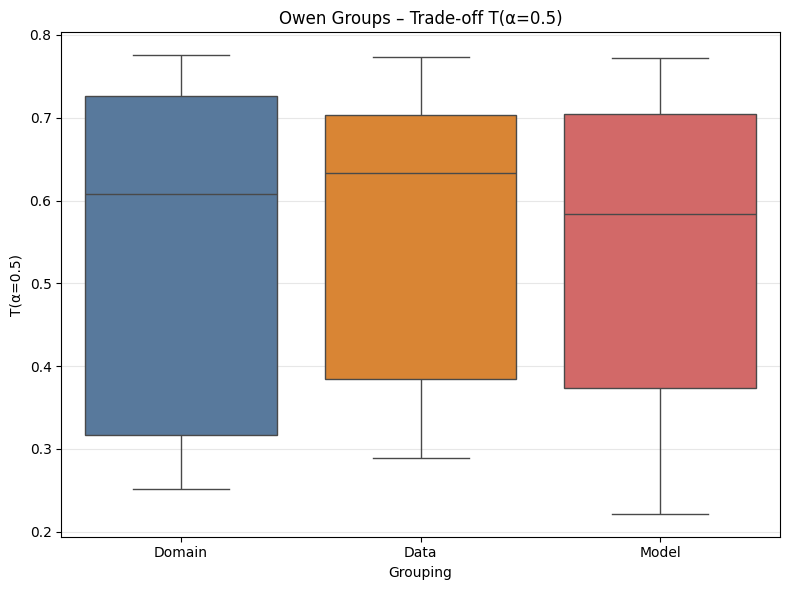

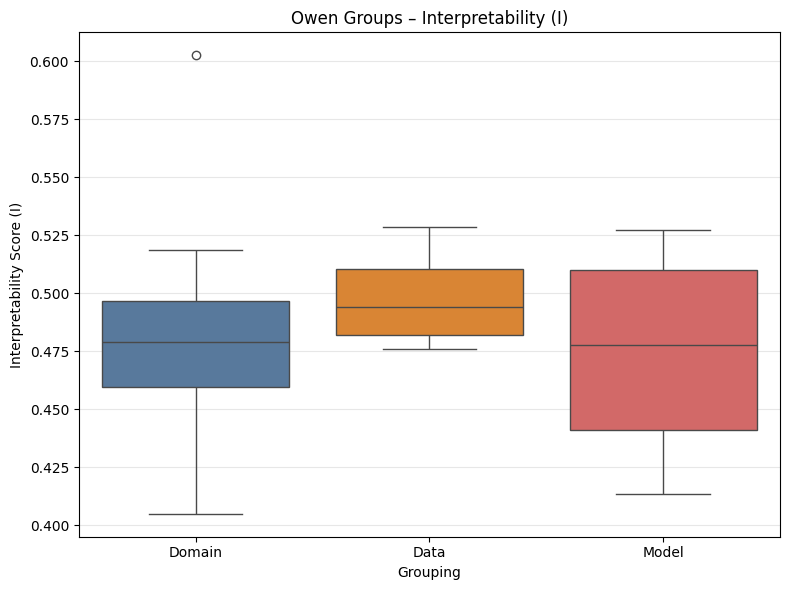

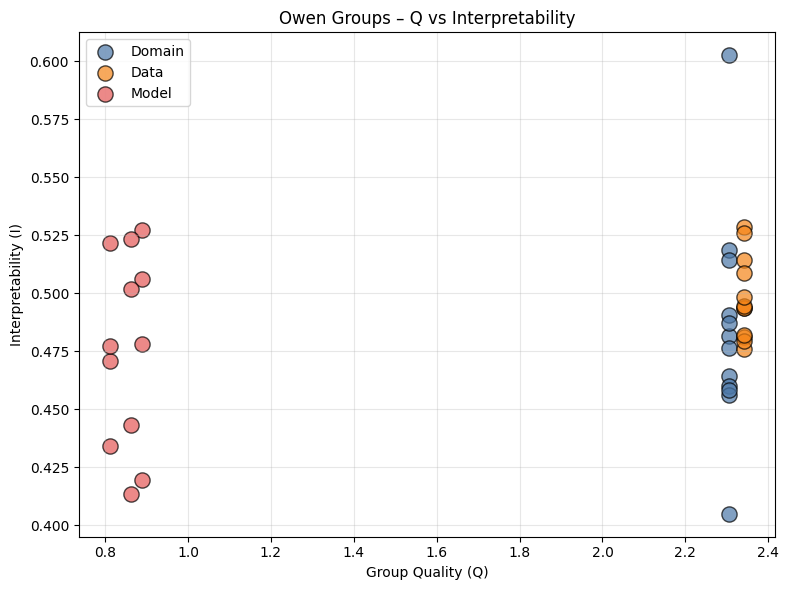

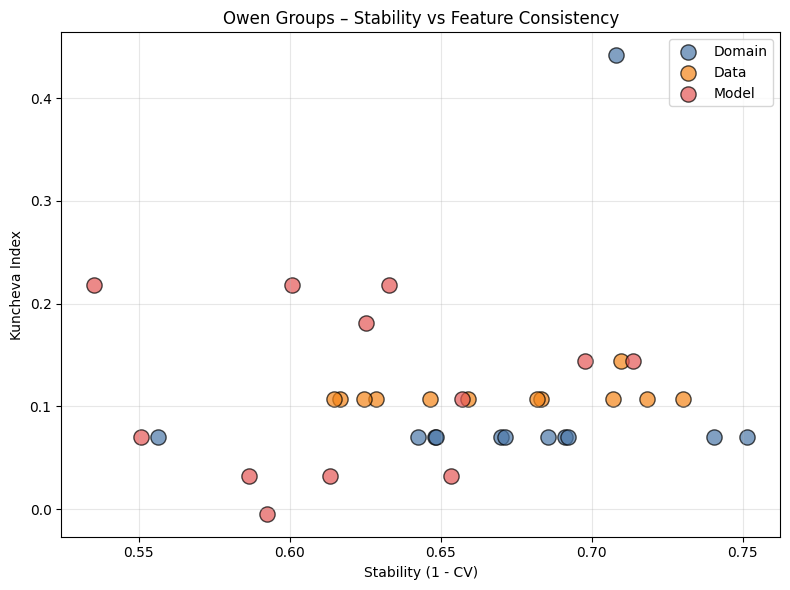

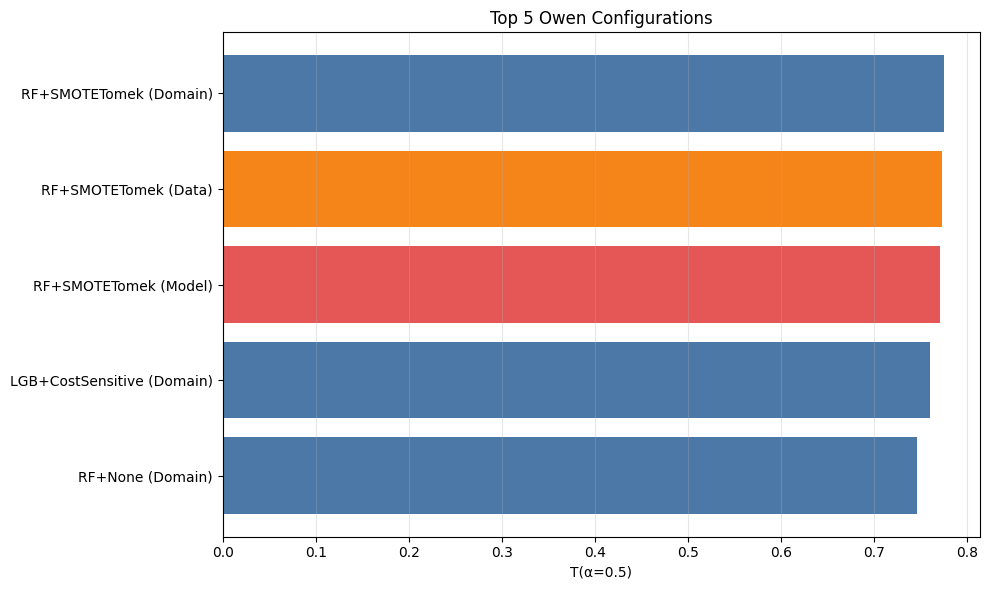


✓ Owen-specific plots generated successfully.


In [23]:
# ============================================================
# OWEN GROUPS – DEDICATED VISUALIZATIONS
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("\n" + "="*80)
print("OWEN GROUPS – DEDICATED VISUALIZATIONS")
print("="*80)

# Filter only Owen rows
owen = metrics[metrics['Method'] == 'Owen'].copy()

# Ensure Grouping column exists
if 'Grouping' not in owen.columns:
    raise ValueError("No 'Grouping' column found for Owen methods.")

# Color palette for groups
group_colors = {
    'Domain': '#4C78A8',
    'Data': '#F58518',
    'Model': '#E45756'
}

# ============================================================
# 1. Trade-off by Owen Grouping
# ============================================================
plt.figure(figsize=(8, 6))
sns.boxplot(data=owen, x='Grouping', y='T(α=0.5)', palette=group_colors)
plt.title("Owen Groups – Trade-off T(α=0.5)")
plt.ylabel("T(α=0.5)")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# 2. Interpretability by Owen Grouping
# ============================================================
plt.figure(figsize=(8, 6))
sns.boxplot(data=owen, x='Grouping', y='I', palette=group_colors)
plt.title("Owen Groups – Interpretability (I)")
plt.ylabel("Interpretability Score (I)")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# 3. Q vs Interpretability (I)
# ============================================================
plt.figure(figsize=(8, 6))
for g in ['Domain', 'Data', 'Model']:
    subset = owen[owen['Grouping'] == g]
    plt.scatter(subset['Q'], subset['I'], s=120, alpha=0.7,
                label=g, color=group_colors[g], edgecolors='black')

plt.xlabel("Group Quality (Q)")
plt.ylabel("Interpretability (I)")
plt.title("Owen Groups – Q vs Interpretability")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# 4. Stability vs Kuncheva
# ============================================================
plt.figure(figsize=(8, 6))
for g in ['Domain', 'Data', 'Model']:
    subset = owen[owen['Grouping'] == g]
    plt.scatter(subset['Stability'], subset['Kuncheva'], s=120, alpha=0.7,
                label=g, color=group_colors[g], edgecolors='black')

plt.xlabel("Stability (1 - CV)")
plt.ylabel("Kuncheva Index")
plt.title("Owen Groups – Stability vs Feature Consistency")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# 5. Top 5 Owen Configurations (bar chart)
# ============================================================
top5_owen = owen.nlargest(5, 'T(α=0.5)')

plt.figure(figsize=(10, 6))
labels = [f"{row.Model}+{row.Sampler} ({row.Grouping})" for _, row in top5_owen.iterrows()]
plt.barh(labels, top5_owen['T(α=0.5)'], color=[group_colors[g] for g in top5_owen['Grouping']])
plt.xlabel("T(α=0.5)")
plt.title("Top 5 Owen Configurations")
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Owen-specific plots generated successfully.")
